In [39]:
import pandas as pd
import numpy as np
from scipy.optimize import minimize
from matplotlib import pyplot as plt

In [33]:
d = pd.read_csv('../tables/merged_observed.csv')

In [34]:
d = d[np.logical_not((d['Ice_Flag_2DS']==1) | (d['ED-liquid_2DS']>=60E-6) | (d['LWC_FCDP']>0.005) | (d['ams_tot'] < 0.04) | (d['N_CCN_stdPT'] < 50))].reset_index(drop=True)
d = d[(d['Org_Ave_IsoK_STP']>=0) & (d['SO4_Ave_IsoK_STP']>=0) & (d['NO3_Ave_IsoK_STP']>=0) & (d['NH4_Ave_IsoK_STP']>=0) & (d['Chl_Ave_IsoK_STP']>=0)].reset_index(drop=True)

In [35]:
def calc_k(data, org_k, so4_k, no3_k, nh4_k, chl_k):
    d = data.copy()

    d['Org_vc'] = d['Org_Ave_IsoK_STP'] / 1000
    d['SO4_vc'] = d['SO4_Ave_IsoK_STP'] / 1770
    d['NO3_vc'] = d['NO3_Ave_IsoK_STP'] / 1770
    d['NH4_vc'] = d['NH4_Ave_IsoK_STP'] / 1770
    d['Chl_vc'] = d['Chl_Ave_IsoK_STP'] / 2200

    d['ams_tot_vc'] = d['Org_vc']+d['SO4_vc']+d['NO3_vc']+d['NH4_vc']+d['Chl_vc']

    d['k'] = org_k*d['Org_vc']/d['ams_tot_vc'] + so4_k*d['SO4_vc']/d['ams_tot_vc'] + no3_k*d['NO3_vc']/d['ams_tot_vc'] + nh4_k*d['NH4_vc']/d['ams_tot_vc'] + chl_k*d['Chl_vc']/d['ams_tot_vc']

    return d

In [49]:
# Define an objective function to minimize
def objective(params, d):
    org_k, so4_k, no3_k, nh4_k, chl_k = params
    k_predicted = calc_k(d, org_k, so4_k, no3_k, nh4_k, chl_k)['k']
    # Calculate the sum of squared differences
    return np.sum((d['k_obs'] - k_predicted)**2)

# Define initial guesses for the kappas
initial_guess = [0.1, 0.1, 0.1, 0.1, 0.1]

# Perform the optimization
result = minimize(objective, initial_guess, args=(d,), method='Nelder-Mead')

# Extract the optimized kappa values
org_k_opt, so4_k_opt, no3_k_opt, nh4_k_opt, chl_k_opt = result.x

print("Optimized kappa values:")
print("org_k:", org_k_opt)
print("so4_k:", so4_k_opt)
print("no3_k:", no3_k_opt)
print("nh4_k:", nh4_k_opt)
print("chl_k:", chl_k_opt)

Optimized kappa values:
org_k: 0.03697754671130018
so4_k: 0.03154126351290026
no3_k: 0.09215610454604242
nh4_k: 0.05973075178346323
chl_k: 0.8482216932254848


In [37]:
result.x

array([0.03697755, 0.03154126, 0.0921561 , 0.05973075, 0.84822169])

(0.0, 0.18)

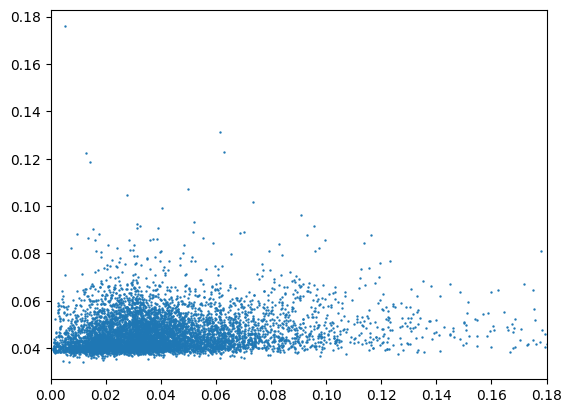

In [50]:
d = calc_k(d, *result.x)
plt.scatter(d['k_obs'], d['k'], s=.5)
plt.xlim([0,.18])